In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 10

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.001,
            'metric' : "EO",
            'lambda': 1.0,
            'lambda_old': 0.0,
            # 'solver': "absolute_minsum_LP_solver_v3",
            # 'converter': "converter_LP_absolute_only_EO",
            
              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=10_epoch=15_lr=0.001_tau=10.0_alpha=0.001_lmbd_1.0_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [5]:
target_label = 0
incremental_step = 1
# cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
to_pil_image(unnormalize(cat_img), mode="RGB")

In [6]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [7]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.850024723545806, 'loss': 0.0019389718700526172, 'EO': [0.09444444444444444, 0.22201834862385322], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6835372069317023, 'classwise_accuracy': {0: array([895, 980]), 1: array([ 893, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 530, 1: 590}, 'class_pred_count_s1': {0: 607, 1: 388}, 'class_pred_count': {0: 1137, 1: 978}, 'count_s0': 1120, 'count_s1': 995, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.9226018160568192, 'loss': 0.0010324257626319327, 'EO': [0.03999999999999998, 0.12293577981651377], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.8370642201834863, 'classwise_accuracy': {1: array([1001, 1135]), 0: array([944, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 590, 0: 530}, 'class_pred_count_s1': {1: 447, 0: 548}, 'class_pred_count': {1: 1037, 0: 1078}, 'count_s0': 1120, 'count_s1': 995, 'count': 2115}

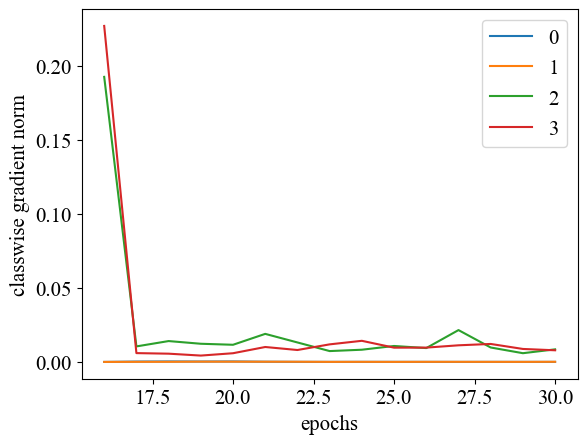

---------------------------- Task 3 -----------------------
Elapsed time(grad):6.279
losses=tensor([[5.2467e-05, 2.2103e-04, 3.8457e-02, 7.9870e-02, 1.3378e+01, 1.2470e+01,
         1.6574e-03, 1.6471e-03, 1.1855e-01, 1.0683e-01, 1.2886e+01, 1.3825e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):13.155
Fairness:[ 0.00473981 -0.01694179  0.06991763  0.02887631 -0.0349158   0.13190811]
Current class expected loss:[ 0.          0.          0.          0.         -3.57332759 -3.77407916]
len(updated_seq_indices)=11263
last one
[31] Eval metrics for task 1 >> {'accuracy': 0.96516901914951, 'loss': 0.0006285323213178215, 'EO': [0.025849056603773568, 0.01128906857409423], 'DP': -1, 'accuracy_s0': 0.982459226095299, 'accuracy_s1': 0.9453211009174312, 'classwise_accuracy': {1: array([1115, 1135]), 0: array([929, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 586, 0: 515, 5: 1, 3: 6, 4: 12}, 'class_pred_count_s1': {1: 529, 3: 11, 0: 414, 2: 20, 5: 14, 4:

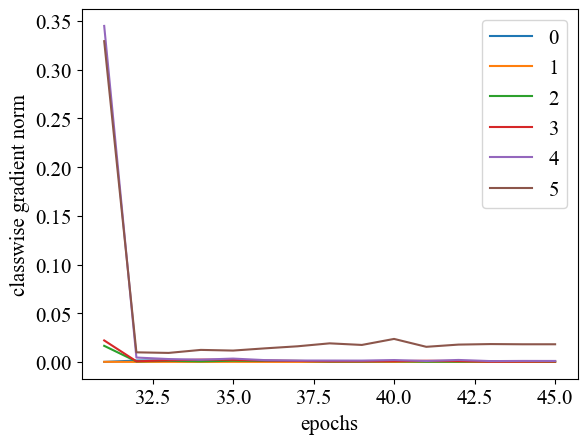

---------------------------- Task 4 -----------------------
Elapsed time(grad):18.784
losses=tensor([[5.6433e-04, 2.4127e-05, 9.6130e-04, 4.7812e-04, 8.6366e-04, 9.2917e-02,
         1.1952e+01, 7.7422e+00, 3.0850e-03, 3.4649e-03, 2.9821e-03, 8.8658e-03,
         8.9266e-02, 5.5134e-01, 1.3438e+01, 1.2316e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):19.241
Fairness:[-0.01629489  0.01545028 -0.04328679  0.03370533  0.06942293  0.01409065
  0.16424219  0.32696532]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
 -3.43771656 -1.95787768]
len(updated_seq_indices)=12183
last one
[46] Eval metrics for task 1 >> {'accuracy': 0.9287624741526567, 'loss': 0.001235634969199521, 'EO': [0.06429769392033541, 0.017773285647644244], 'DP': -1, 'accuracy_s0': 0.9668212344099776, 'accuracy_s1': 0.884750254841998, 'classwise_accuracy': {0: array([887, 980]), 1: array([1081, 1135])}, 'DP_ingredients': {'class_pred_count_s0':

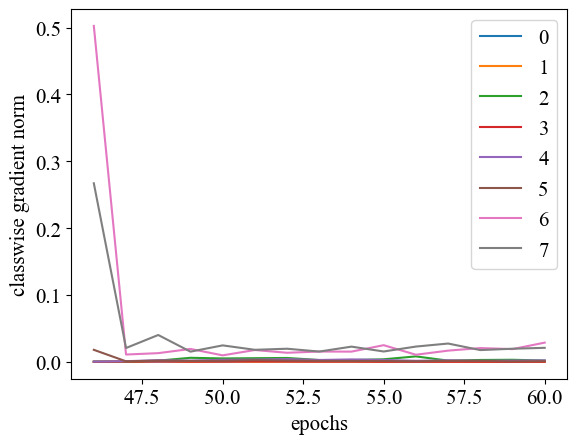

---------------------------- Task 5 -----------------------
Elapsed time(grad):16.035
losses=tensor([[9.0599e-04, 2.7986e-04, 1.5565e-02, 8.4115e-04, 2.4254e-03, 2.2036e-03,
         5.7372e-02, 1.1592e-01, 1.3565e+01, 1.5825e+01, 6.8854e-03, 2.4960e-03,
         9.8955e-03, 1.8811e-02, 1.0019e-02, 4.7689e-03, 2.1006e-01, 1.5870e-01,
         1.3582e+01, 1.5807e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):23.757
Fairness:[ 0.00287284  0.00120335  0.00556107 -0.02695342  0.00721764  0.0068449
  0.02012075  0.01139797  0.01108791  0.00442034]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
  0.          0.         -4.24575075 -5.33328079]
len(updated_seq_indices)=11800
last one
[61] Eval metrics for task 1 >> {'accuracy': 0.9209475860828913, 'loss': 0.001369838575099377, 'EO': [0.04570230607966458, 0.031184885709842958], 'DP': -1, 'accuracy_s0': 0.9569075791493444, 'accuracy_s1': 0.8800203873598369, 'class

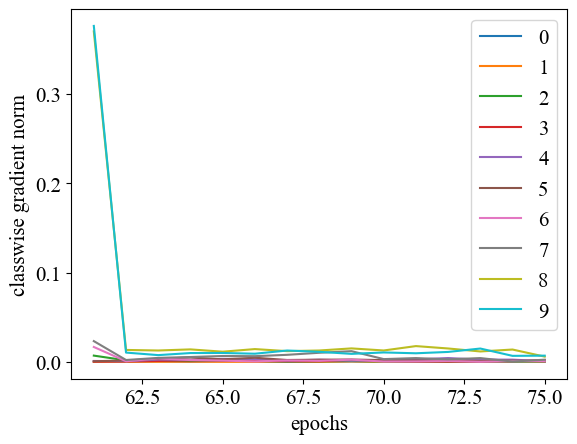

final avg-acc 0.8243031975238096
final avg-forget 0.14444817157788492


In [8]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [9]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.997, 0.   , 0.   , 0.   , 0.   ],
       [0.967, 0.952, 0.   , 0.   , 0.   ],
       [0.95 , 0.836, 0.911, 0.   , 0.   ],
       [0.916, 0.773, 0.891, 0.938, 0.   ],
       [0.879, 0.728, 0.729, 0.885, 0.9  ]])

In [10]:
# cplex:
# 0.9118084997437294
# 0.06460678611442798
# 0.008188548244547547

# 0.9091395386242567
# 0.06660037700595048
# 0.008848272564364903

# 0.9151675941037339
# 0.05388215967057982
# 0.00931822630644371

In [11]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.911931438749437

In [12]:
[np.round(x, 3) for x in metric_manager_callback.meters['EO'].compute_overall()]

[0.003, 0.032, 0.07, 0.06, 0.107]

In [13]:
np.mean(metric_manager_callback.meters['EO'].compute_overall())

0.05454652460272391

In [14]:
[np.round(x, 3) for x in metric_manager_callback.meters['DP'].compute_overall()]

[0.008, 0.007, 0.009, 0.01, 0.013]

In [15]:
np.mean(metric_manager_callback.meters['DP'].compute_overall())

0.009333070979077287

In [16]:
task_id = 2

print(f"{task_id=}")
print(f"sensitive samples / all samples = {(benchmark.trains[task_id].sensitives != benchmark.trains[task_id].targets).sum().item()} / {benchmark.trains[task_id].sensitives.shape[0]}")

updated_seq_indices = benchmark.seq_indices_train[task_id]
print(f"sensitive samples / selected samples = {(benchmark.trains[task_id].sensitives[updated_seq_indices] != benchmark.trains[task_id].targets[updated_seq_indices]).sum().item()} / {len(updated_seq_indices)}")


task_id=2
sensitive samples / all samples = 604 / 12089
sensitive samples / selected samples = 604 / 12089


In [17]:
step_class = 2
for i in range(2, 6):
    incremental_step = i
    print(f"{incremental_step=}")
    one_idx = benchmark.trains[incremental_step].sample_weight > 0.9

    print(f"{2*i-2} : {(benchmark.trains[incremental_step].targets == (2*i-2)).sum().item()} --> {(benchmark.trains[incremental_step].targets[one_idx] == (2*i-2)).sum().item()}")
    print(f"{2*i-1} : {(benchmark.trains[incremental_step].targets == (2*i-1)).sum().item()} --> {(benchmark.trains[incremental_step].targets[one_idx] == (2*i-1)).sum().item()}")


incremental_step=2
2 : 5958 --> 1519
3 : 6131 --> 1522
incremental_step=3
4 : 5842 --> 602
5 : 5421 --> 1085
incremental_step=4
6 : 5918 --> 362
7 : 6265 --> 329
incremental_step=5
8 : 5851 --> 580
9 : 5949 --> 898


In [18]:
metric_manager_callback.meters['classwise_accuracy'].get_data()

[{1: array([1130, 1135]), 0: array([979, 980])},
 {1: array([1110, 1135]),
  0: array([937, 980]),
  3: array([ 961, 1010]),
  2: array([ 983, 1032])},
 {0: array([907, 980]),
  1: array([1106, 1135]),
  3: array([ 839, 1010]),
  2: array([ 868, 1032]),
  4: array([960, 982]),
  5: array([754, 892])},
 {1: array([1082, 1135]),
  0: array([861, 980]),
  3: array([ 803, 1010]),
  2: array([ 775, 1032]),
  4: array([886, 982]),
  5: array([784, 892]),
  6: array([903, 958]),
  7: array([ 960, 1028])},
 {0: array([840, 980]),
  1: array([1023, 1135]),
  3: array([ 706, 1010]),
  2: array([ 782, 1032]),
  5: array([650, 892]),
  4: array([716, 982]),
  7: array([ 867, 1028]),
  6: array([887, 958]),
  9: array([ 868, 1009]),
  8: array([916, 974])}]